**DATA 3320 Final Project**

Niko van Stipdonk

Kian Farzaneh

Amsalu Shmidt


Part 1: Data Preprocessing

In [ ]:
#importing relevant packages

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
# mounting google drive

from google.colab import drive
drive.mount('/content/gdrive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# loading in the data

columns = ['rider_id', 'request_id', 'ride_type', 'upfront_fare', 'eta_to_rider_pre_match',
           'eta_to_rider_post_match', 'requested_at_local', 'accepted_at_local', 'cancellation_flag',
           'cancel_penalty']

df = pd.read_csv('gdrive/My Drive/dat.csv', names=columns, header=0)
df = df.dropna()

Part 2: Feature Engineering

In [ ]:
# getting rid of the timezone string and converting the data into datetime format

df['requested_at_local'] = df['requested_at_local'].str.replace(' America/Los_Angeles', '', regex=False)
df['accepted_at_local'] = df['accepted_at_local'].str.replace(' America/Los_Angeles', '', regex=False)

df['requested_at_local'] = pd.to_datetime(df['requested_at_local'], format="%Y-%m-%d %H:%M:%S.%f")
df['accepted_at_local'] = pd.to_datetime(df['accepted_at_local'], format="%Y-%m-%d %H:%M:%S.%f")

# creating the features that show the time to accept after requested and the eta difference between pre and post match

df['request_to_accept_seconds'] = (df['accepted_at_local'] - df['requested_at_local']).dt.total_seconds()
df['eta_difference'] = df['eta_to_rider_post_match'] - df['eta_to_rider_pre_match']

# time features

df['day_of_week'] = df['requested_at_local'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# extract hour from timestamp
df['hour_of_day'] = df['requested_at_local'].dt.hour

# define time-of-day segments
def map_time_segment(hour):
    if 7 <= hour < 10:
        return 'Morning Rush'
    elif 10 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 19:
        return 'Evening Rush'
    elif 19 <= hour < 23:
        return 'Evening'
    else:
        return 'Late Night'

# apply function
df['time_of_day_segment'] = df['hour_of_day'].apply(map_time_segment)

# convert to categorical dtype for model use
df['time_of_day_segment'] = pd.Categorical(
    df['time_of_day_segment'],
    categories=['Morning Rush', 'Midday', 'Evening Rush', 'Evening', 'Late Night'],
    ordered=True
)

df = pd.get_dummies(df, columns=['time_of_day_segment'], drop_first=True)

<ipython-input-5-448c598e6147>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancel_rate_by_penalty = df.groupby('cancel_penalty')['cancellation_flag'].mean().reset_index()


  Penalty Amount ($)  Cancellation Rate
0                  1           0.168844
1                  3           0.133778
2                  5           0.079007


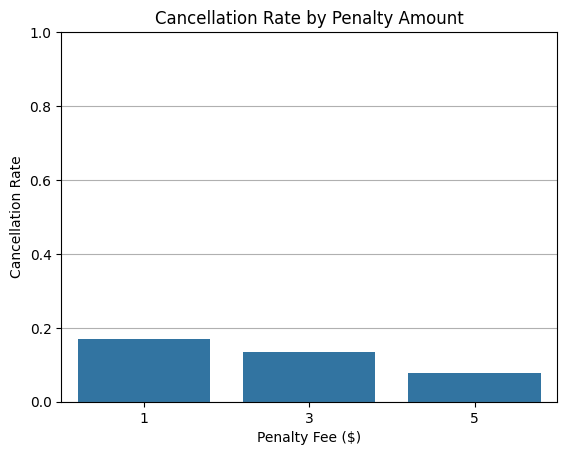

In [ ]:
# making cancel_penalty categorical

df['cancel_penalty'] = df['cancel_penalty'].astype('category')

cancel_rate_by_penalty = df.groupby('cancel_penalty')['cancellation_flag'].mean().reset_index()
cancel_rate_by_penalty.columns = ['Penalty Amount ($)', 'Cancellation Rate']

print(cancel_rate_by_penalty)

sns.barplot(data=cancel_rate_by_penalty, x='Penalty Amount ($)', y='Cancellation Rate')
plt.title("Cancellation Rate by Penalty Amount")
plt.ylabel("Cancellation Rate")
plt.xlabel("Penalty Fee ($)")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()

df = pd.get_dummies(df, columns=['cancel_penalty'], drop_first=True)

Percentage of first-time riders: 38.17%


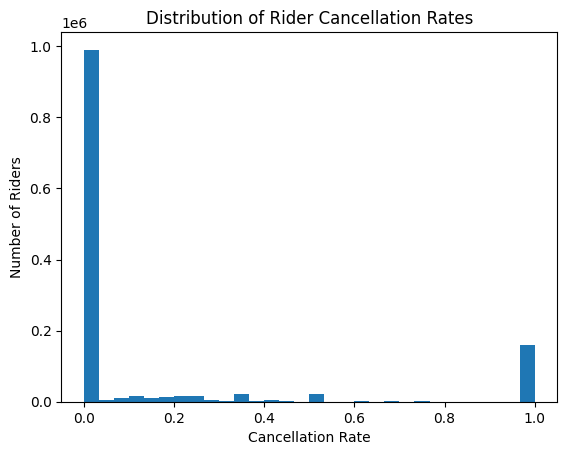

<Figure size 600x600 with 0 Axes>

count    1.302247e+06
mean     1.546462e-01
std      3.322854e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: cancel_rate, dtype: float64


In [ ]:
# finding if the rider has canceled before
df.sort_values(by=['rider_id', 'requested_at_local'], inplace=True)

df['prior_cancellations'] = (
    df.groupby('rider_id')['cancellation_flag']
    .cumsum()
    .shift(fill_value=0)
)

df['has_canceled_before'] = (df['prior_cancellations'] > 0).astype(int)

df['prior_requests'] = (
    df.groupby('rider_id')
    .cumcount()
)

df['cancel_rate'] = df['prior_cancellations'] / (df['prior_requests'].replace(0, 1))
df['cancel_rate'] = df['cancel_rate'].clip(upper=1)

df['is_first_time'] = (df['prior_requests'] == 0).astype(int)

first_time_rate = df['is_first_time'].mean()
print(f"Percentage of first-time riders: {first_time_rate * 100:.2f}%")

# drop helper columns after creating final features
df = df.drop(columns=['prior_cancellations', 'prior_requests'])

# plotting the distribution of rider cancellations

plt.hist(df['cancel_rate'], bins=30)
plt.xlabel('Cancellation Rate')
plt.ylabel('Number of Riders')
plt.title('Distribution of Rider Cancellation Rates')
plt.figure(figsize=(6, 6))
plt.show()

print(df['cancel_rate'].describe())


In [ ]:
# drop unneeded columns before encoding
df = df[df['cancel_rate'].round(4) < 1.0] # removing extreme outliers (riders who have never completed a ride)

df_log = df.drop(columns=['rider_id', 'request_id', 'requested_at_local', 'accepted_at_local'])

df_log = pd.get_dummies(df_log, columns=['ride_type'], drop_first=True)

X = df_log.drop(columns=['cancellation_flag'])
y = df_log['cancellation_flag']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

Part 3.1: Modeling for Cancellation (Logistic Regression - Continuous Cancel Rate)

Logistic Regression Accuracy: 0.9098079975083245


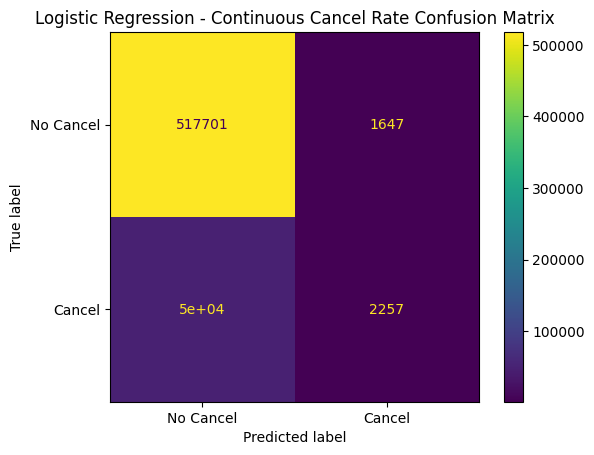

                             Feature  Coefficient  Odds_Ratio
16                     is_first_time     0.398205       1.489
2            eta_to_rider_post_match     0.341230       1.407
4                     eta_difference     0.266357       1.305
15                       cancel_rate     0.264720       1.303
1             eta_to_rider_pre_match     0.137943       1.148
14               has_canceled_before     0.062657       1.065
3          request_to_accept_seconds     0.011398       1.011
6                         is_weekend     0.000384       1.000
5                        day_of_week    -0.009495       0.991
11    time_of_day_segment_Late Night    -0.021890       0.978
7                        hour_of_day    -0.027284       0.973
0                       upfront_fare    -0.031362       0.969
9   time_of_day_segment_Evening Rush    -0.045760       0.955
10       time_of_day_segment_Evening    -0.050049       0.951
12                  cancel_penalty_3    -0.064806       0.937
17      

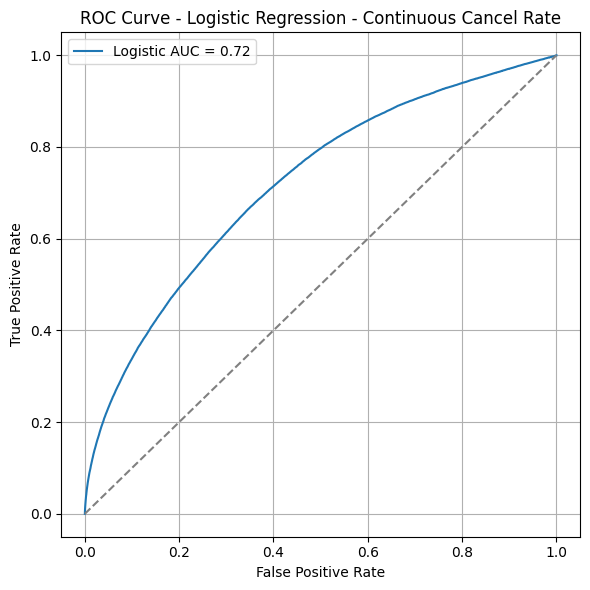

Specificity (True Negative Rate): 0.997


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Cancel", "Cancel"])
disp.plot()
plt.title("Logistic Regression - Continuous Cancel Rate Confusion Matrix")
plt.show()

coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
coef_df['Odds_Ratio'] = coef_df['Coefficient'].apply(lambda x: round(np.exp(x), 3))
coef_df = coef_df.sort_values(by='Odds_Ratio', ascending=False)
print(coef_df)

y_scores_log = log_reg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
auc_log = roc_auc_score(y_test, y_scores_log)

plt.figure(figsize=(6, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic AUC = {auc_log:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - Continuous Cancel Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.3f}")

Part 3.2: Modeling for Cancellation (Random Forest - Continuous Cancel Rate)

Random Forest Accuracy: 0.6568434461411401


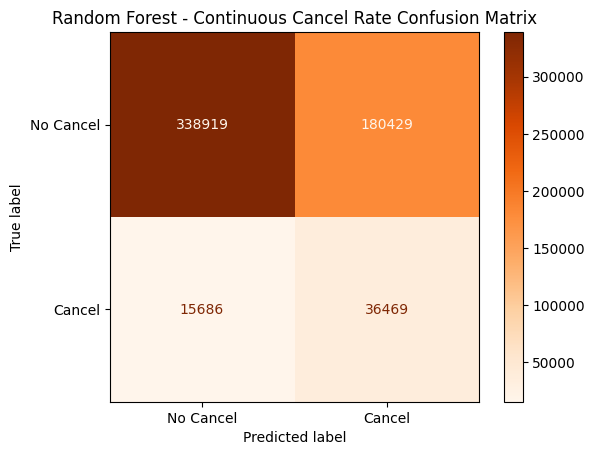

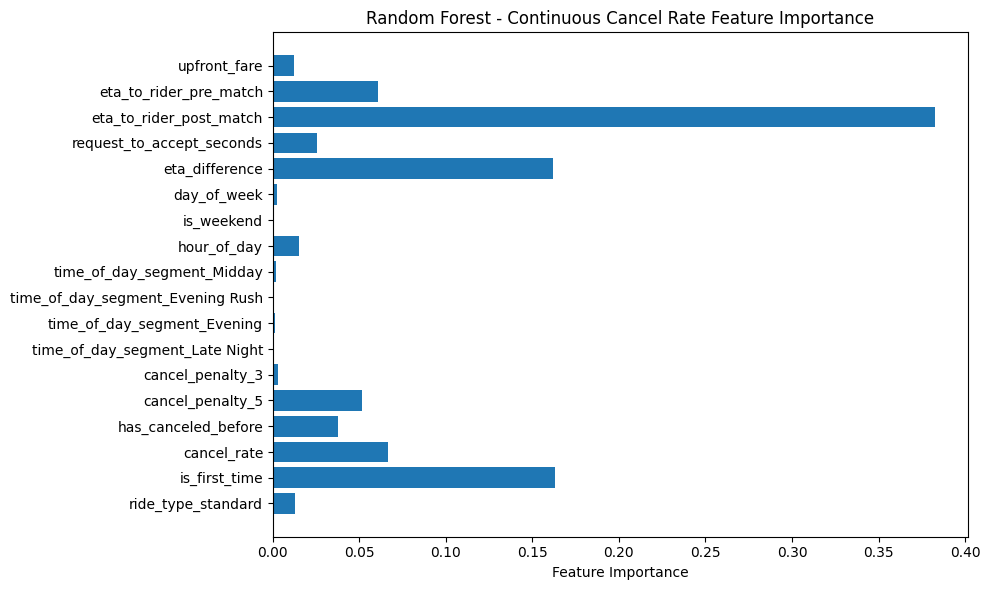

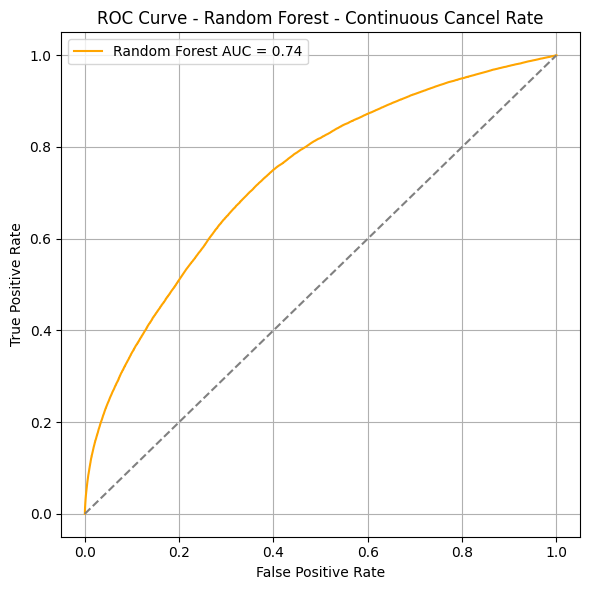

Specificity (True Negative Rate): 0.997


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=25, random_state=42, max_depth = 8, class_weight="balanced", min_samples_split = 250)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Cancel", "Cancel"])
disp_rf.plot(cmap='Oranges')
plt.title("Random Forest - Continuous Cancel Rate Confusion Matrix")
plt.show()

importances_rf = rf_clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances_rf)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Continuous Cancel Rate Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

y_scores_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
auc_rf = roc_auc_score(y_test, y_scores_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc_rf:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Continuous Cancel Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.3f}")

In [ ]:
df['cancel_rate_bucket'] = pd.cut(
    df['cancel_rate'].clip(upper=1),
    bins=[-0.01, 0, 0.1, 0.5, 1.0],
    labels=['No Cancellations', 'Low', 'Medium', 'High']


)

df_log2 = df.drop(columns=['rider_id', 'request_id', 'requested_at_local', 'accepted_at_local', 'cancel_rate', 'has_canceled_before'])

df_log2 = pd.get_dummies(df_log2, columns=['ride_type', 'cancel_rate_bucket'], drop_first=True)

X = df_log2.drop(columns=['cancellation_flag'])
y = df_log2['cancellation_flag']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

Part 3.3: Modeling for Cancellation (Logistic Regression - Bucketed Cancel Rate)

Logistic Regression Accuracy: 0.909802748192048


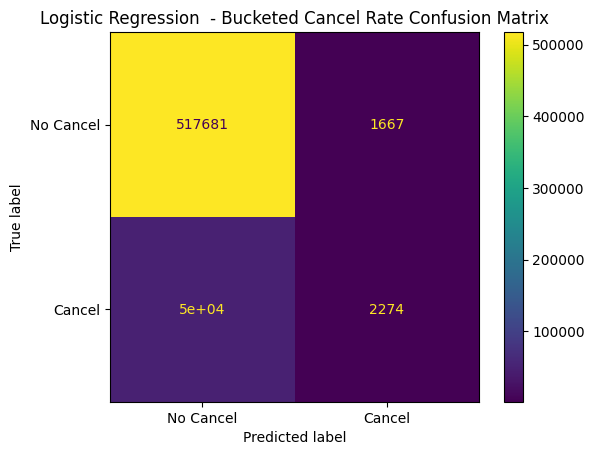

                             Feature  Coefficient  Odds_Ratio
14                     is_first_time     0.397271       1.488
2            eta_to_rider_post_match     0.341292       1.407
17         cancel_rate_bucket_Medium     0.272104       1.313
4                     eta_difference     0.265004       1.303
18           cancel_rate_bucket_High     0.165354       1.180
1             eta_to_rider_pre_match     0.139076       1.149
16            cancel_rate_bucket_Low     0.038774       1.040
3          request_to_accept_seconds     0.010385       1.010
6                         is_weekend     0.000367       1.000
5                        day_of_week    -0.008545       0.991
11    time_of_day_segment_Late Night    -0.022676       0.978
7                        hour_of_day    -0.028581       0.972
0                       upfront_fare    -0.029919       0.971
9   time_of_day_segment_Evening Rush    -0.045188       0.956
10       time_of_day_segment_Evening    -0.048588       0.953
12      

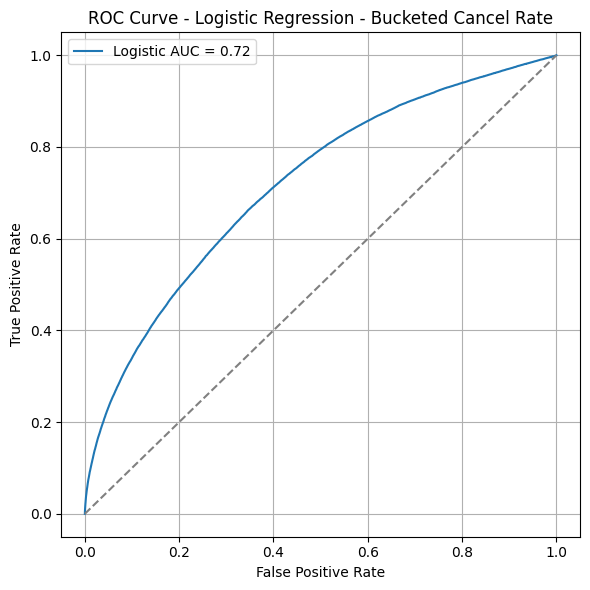

Specificity (True Negative Rate): 0.997


In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Cancel", "Cancel"])
disp.plot()
plt.title("Logistic Regression  - Bucketed Cancel Rate Confusion Matrix")
plt.show()

coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
coef_df['Odds_Ratio'] = coef_df['Coefficient'].apply(lambda x: round(np.exp(x), 3))
coef_df = coef_df.sort_values(by='Odds_Ratio', ascending=False)
print(coef_df)

y_scores_log = log_reg.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
auc_log = roc_auc_score(y_test, y_scores_log)

plt.figure(figsize=(6, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic AUC = {auc_log:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - Bucketed Cancel Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.3f}")

Part 3.4: Modeling for Cancellation (Random Forest - Bucketed Cancel Rate)

Random Forest Accuracy: 0.6608836699019953


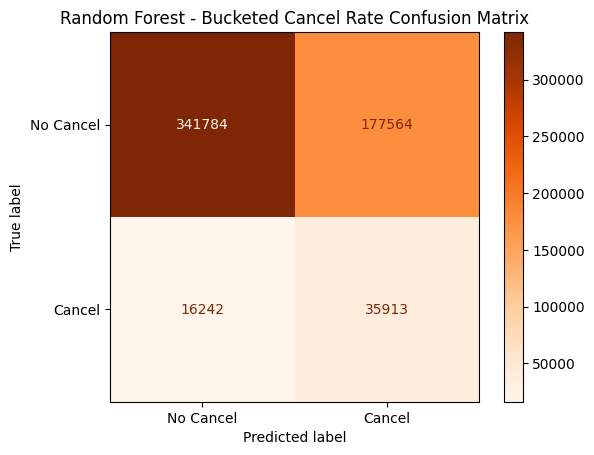

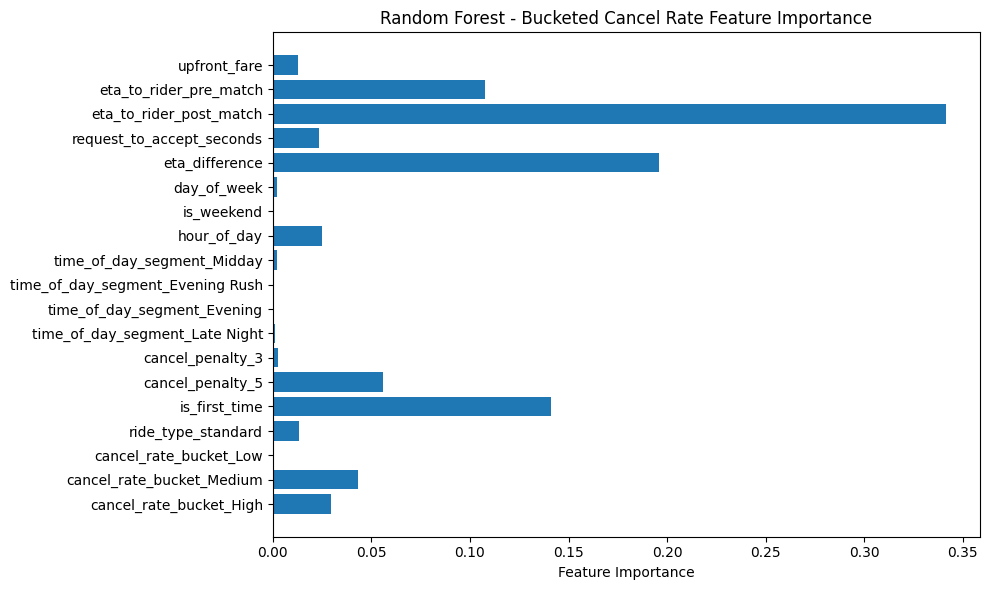

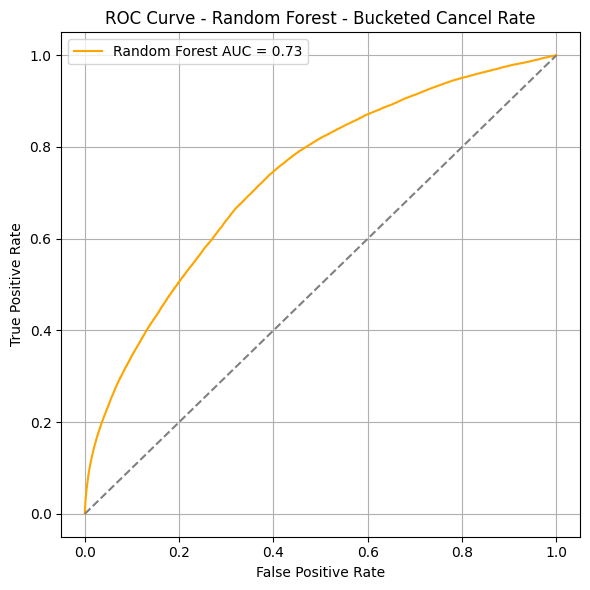

Specificity (True Negative Rate): 0.997


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=25, random_state=42, max_depth = 8, class_weight="balanced", min_samples_split = 250)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Cancel", "Cancel"])
disp_rf.plot(cmap='Oranges')
plt.title("Random Forest - Bucketed Cancel Rate Confusion Matrix")
plt.show()

importances_rf = rf_clf.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances_rf)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Bucketed Cancel Rate Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

y_scores_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
auc_rf = roc_auc_score(y_test, y_scores_rf)

plt.figure(figsize=(6, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest AUC = {auc_rf:.2f}', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - Bucketed Cancel Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.3f}")

Part 4: Modeling Ride Requests


RMSE: 0.72
R² Score: 0.076

Top Features Influencing Number of Requests:
                       Feature  Importance
0                 upfront_fare    0.640024
12          ride_type_standard    0.158955
7                  hour_of_day    0.073832
5                  day_of_week    0.066392
1       eta_to_rider_pre_match    0.020215
3    request_to_accept_seconds    0.014492
2      eta_to_rider_post_match    0.012798
4               eta_difference    0.005812
8   time_of_day_segment_Midday    0.002897
6                   is_weekend    0.001919


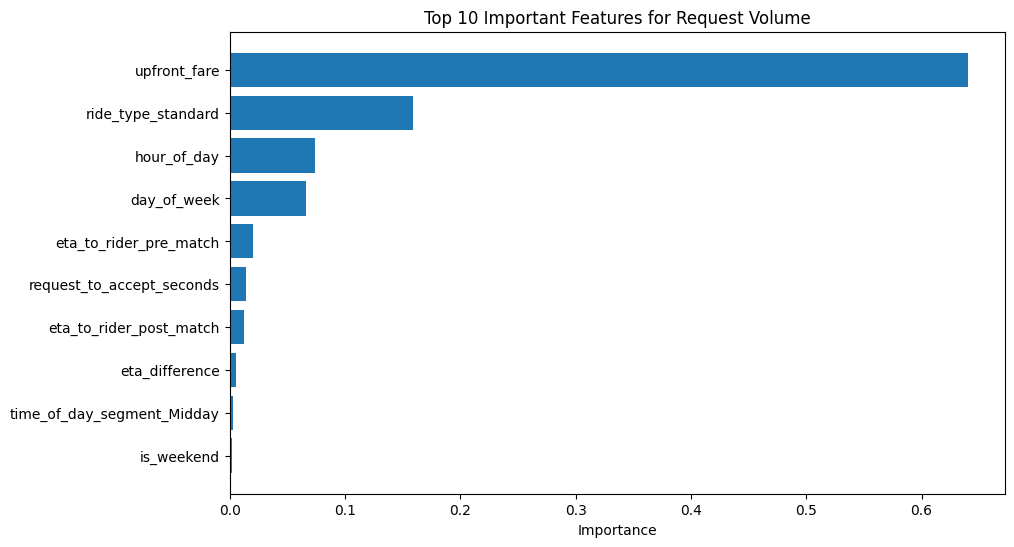

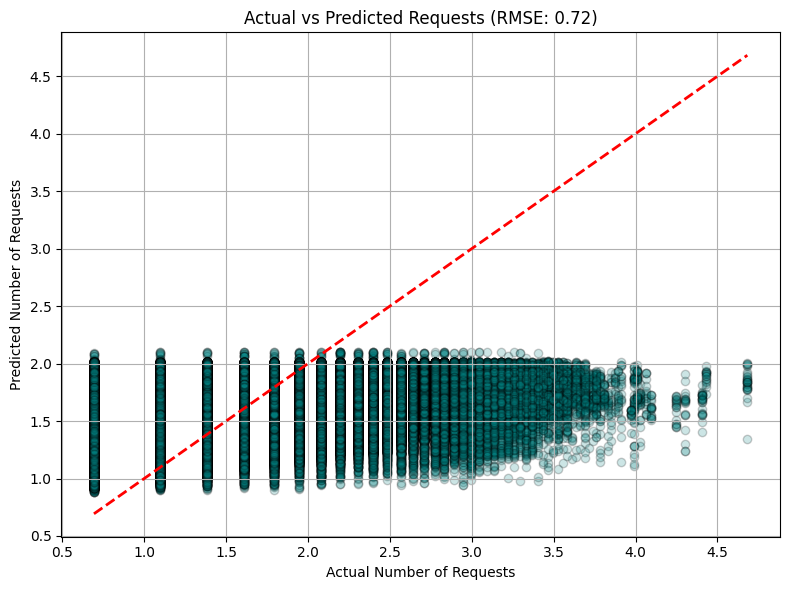

In [ ]:
# create target: num_requests per rider
requests_per_rider = df.groupby('rider_id').size().reset_index(name='num_requests')

# merge the number of requests back into the main dataframe
df_with_requests = df.merge(requests_per_rider, on='rider_id')

# prepare features and target for regression
drop_cols = [
    'rider_id', 'request_id', 'requested_at_local', 'accepted_at_local', 'cancellation_flag',
    'cancel_rate', 'has_canceled_before', 'cancel_rate_bucket', 'cancel_penalty_3', 'cancel_penalty_5',
    'cancel_penalty_1', 'is_first_time'
]
df_reg = df_with_requests.drop(columns=drop_cols, errors='ignore')

df_reg = pd.get_dummies(df_reg, columns=['ride_type'], drop_first=True)


X_reg = df_reg.drop(columns=['num_requests'])
y_reg = np.log1p(df_reg['num_requests'])

# standardize features
X_reg_scaled = scaler.fit_transform(X_reg)

# train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_scaled, y_reg, test_size=0.3, random_state=42)

# use RandomForestRegressor for this regression task
rf_reg = RandomForestRegressor(n_estimators=25, random_state=42, max_depth = 8, min_samples_split = 250)
rf_reg.fit(X_train_reg, y_train_reg)

# predict and evaluate
y_pred_reg = rf_reg.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"\nRMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# feature importance
feature_importance_reg = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Features Influencing Number of Requests:")
print(feature_importance_reg.head(10))

# plot top features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_reg['Feature'][:10], feature_importance_reg['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Important Features for Request Volume')
plt.gca().invert_yaxis()
plt.show()

# RMSE
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.2, color='teal', edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()],
         'r--', lw=2)
plt.xlabel('Actual Number of Requests')
plt.ylabel('Predicted Number of Requests')
plt.title(f'Actual vs Predicted Requests (RMSE: {rmse:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()